In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import plotly.offline
import plotly.graph_objs as go

In [3]:
df = pd.read_csv("logs_limpios.csv")

In [116]:
text_list_complete = df["Preguntas"].to_list()

---
> ### 0: ***Preparación de la data para el ploteo***
---

In [121]:
def data_plot_image(data_plot, model_cluster, text):
    pos_x = [x[0] for x in data_plot]
    pos_y = [x[1] for x in data_plot]
    
    dic_plot = {}

    for i in range(len(model_cluster)):
        if model_cluster[i] not in dic_plot:
            dic_plot[model_cluster[i]] = [[pos_x[i]],[pos_y[i]], [model_cluster[i]], [text[i]]]
        # Agrego la posición en X
        dic_plot[model_cluster[i]][0].append(pos_x[i])  
        # Agrego la posición en Y
        dic_plot[model_cluster[i]][1].append(pos_y[i])    
        # Agrego el número de "cluster"
        dic_plot[model_cluster[i]][2].append(model_cluster[i])
        # Agrego la pregunta
        dic_plot[model_cluster[i]][3].append(text[i])
        
    # Cantidad de intenciones detectadas
    amount_clusters = len(dic_plot.keys())

    plot = []
    for intents in dic_plot:
        trace = go.Scatter(
            x = dic_plot[intents][0],
            y = dic_plot[intents][1],
            text = dic_plot[intents][3],
            name = str(intents),
            mode = 'markers',
            marker = dict(
                size = 7
            )
        )
        plot.append(trace)
        
    print(f"---> La cantidad de clusters detectados fueron de {amount_clusters}")    
    return plot

---
> ### 1: ***Stemizar y sacar las stopwords del texto***
---

In [6]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

stemmer = SnowballStemmer('spanish')
cachedStopWords = stopwords.words('spanish')


def clean_text(text_list):
    for i in range(len(text_list)):
        text = ' '.join([stemmer.stem(word) for word in text_list[i].split() if word not in cachedStopWords])
        text_list[i] = text
    return text_list

In [7]:
text_list = clean_text(text_list_complete)

---
> ### 2: ***Vectorizar el texto utilizando Tf-idf (TfidfVectorizer) o BOW (CountVectorizer)***

### Diferencias entre las dos
---

In [161]:
vectorizer_tfidf = TfidfVectorizer()
vectorizer_bow = CountVectorizer()

In [162]:
data = vectorizer_tfidf.fit_transform(text_list)

---
> ### ***Gráfico de energía***
---

In [79]:
from scipy.sparse.linalg import eigs

matrix = np.matmul(data.toarray(), data.toarray().transpose())
vals, vecs = eigs(matrix, 20)

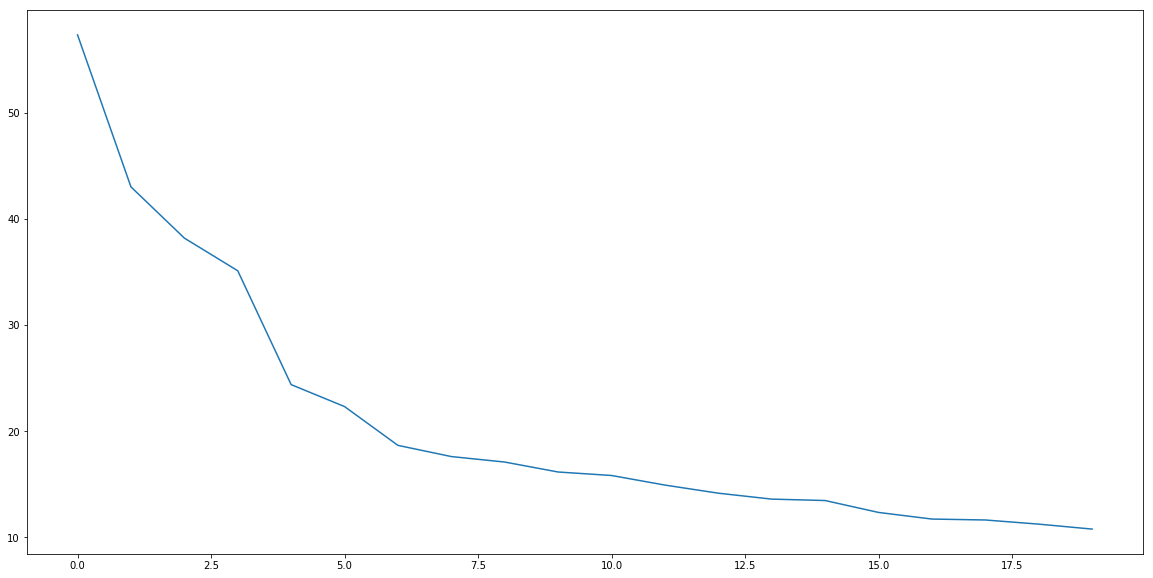

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(vals);

---
> ### 3: ***Aplicar SVD/PCA y reducir las dimensiones dependiendo del gráfico de energía***
---

In [136]:
svd = TruncatedSVD(n_components=3)
svd_truncated = svd.fit_transform(data)

---
> ### 3: ***Aplicar T-SNE para reducir todo a 2 dimensiones***
---

In [198]:
# method = 'exact' corre un algorito más exacto pero de complejidad O(N^2)

data_2d = TSNE(n_components=2, n_iter=8000, perplexity=40)
data_2d = data_2d.fit_transform(svd_truncated)

In [174]:
data_plot = data_2d

---
> ### 4: ***Ploteo la data para ver qué algoritmo de clustering utilizar***
---

In [199]:
plot = []
pos_x = [x[0] for x in data_plot]
pos_y = [x[1] for x in data_plot]

trace = go.Scatter(
    x = pos_x,
    y = pos_y,
    text = text_list_complete,
    mode = 'markers',
    marker = dict(
        size = 7
    )
)
plot.append(trace)
plotly.offline.plot(plot)

'file:///Users/nicolas.bugliot/Documents/Trabajo/ML/Clustering/temp-plot.html'

---
> ### Tipo de clustering: ***K-MEANS++***
---

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit_predict(data_plot)

In [14]:
plotly.offline.plot(data_plot_image(data_plot, kmeans));

---> La cantidad de clusters detectados fueron de 20


---
> ### Tipo de clustering: ***Spectral Clustering***
---

In [185]:
%%time
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(n_clusters=10, assign_labels="discretize", random_state=0).fit(data_plot)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



KeyboardInterrupt: 

In [186]:
plotly.offline.plot(data_plot_image(data_plot, spectral_clustering.labels_, text_list_complete));

---> La cantidad de clusters detectados fueron de 10


---
> ### Tipo de clustering: ***DBSCAN***
---

In [179]:
from sklearn.cluster import DBSCAN

In [195]:
# eps es el hiper-parámetro que define el radio del radar.
dbscan_clustering = DBSCAN(eps=5, min_samples=15).fit(data_plot)

In [196]:
plotly.offline.plot(data_plot_image(data_plot, dbscan_clustering.labels_, text_list_complete));

---> La cantidad de clusters detectados fueron de 8


---
> ### Tipo de clustering: ***HDBSCAN***
---

In [182]:
import hdbscan

In [183]:
%%time
hdbscan_cluster = hdbscan.HDBSCAN()
hdbscan_cluster = hdbscan_cluster.fit(data_plot)

CPU times: user 37.3 ms, sys: 8.51 ms, total: 45.8 ms
Wall time: 44.6 ms


In [184]:
plotly.offline.plot(data_plot_image(data_plot, hdbscan_cluster.labels_, text_list_complete));

---> La cantidad de clusters detectados fueron de 18
